In [2]:
import geopandas
import numpy
import numpy
import math
import shapely
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../') 
import datastructure

19272

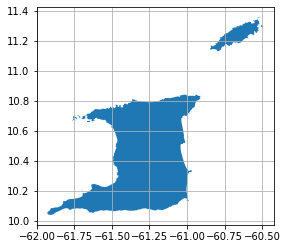

In [844]:
# Loading the geometries
fig, ax = plt.subplots()
ax.grid(True)

# 3:4 is canada 29:30 Brazil
polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))#[4:5]
polygons = polygons[polygons.name =='Canada']

# 3:4 is trinidad
#polygons = geopandas.read_file('../data/caribbean.gpkg')[20:21]
polygons = geopandas.read_file('../data/caribbean.gpkg')[3:4]

#polygons = geopandas.read_file('../data/santa_barbara.gpkg')

polygons.plot(ax=ax)

geom_type = polygons.iloc[0].geometry.type
if  geom_type == 'Polygon':
    # We drop the last point because it is a repetition of the first point
    lon = polygons.iloc[0].geometry.exterior.xy[0]
    lat = polygons.iloc[0].geometry.exterior.xy[1]
elif geom_type == 'MultiPolygon':
    lon = []
    lat = []
    for p in list(polygons.iloc[0].geometry):
        lon += p.exterior.xy[0]
        lat += p.exterior.xy[1]

# Dirty trick to get rid of duplicate points
#lat, lon = zip(*(set(zip(lat, lon))))

#lat, lon = zip(*list(dict.fromkeys(zip(lat, lon))))
len(lat)

In [845]:
#lon, lat = polygons.geometry.iloc[0][0].exterior.xy

In [846]:
lon = numpy.array(lon)
lat = numpy.array(lat)

# We convert to ECEF vectors
x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

# We create a nx3 matrix of the points 
nodes = numpy.array([x, y, z]).transpose()

n = len(x)

In [847]:
def insert_node(node_index):
    
    # Nothing to do if point is already in set of convex hull nodes
    if node_index in convex_nodes:
        return convex_nodes
    
    # Nothing to do if a node of same location as the point is already in convex
    for node in convex_nodes:
        if numpy.array_equal(nodes[node_index], nodes[node]):
            return convex_nodes
    
    # What is the first constraint outside which our point lies?
    insertion = -1
    for edge_index in range(len(edges)):
        direction = numpy.dot(edges[edge_index], nodes[node_index])
        if  direction < 0:
            insertion = edge_index
            break
    
    # If the point is inside all constraints, it can be discarded
    if insertion == -1:
        return convex_nodes
        
    # Otherwise we insert the point in the gap between 
    # the nodes that define the constraint outside which the point lies
    convex_nodes.insert(insertion+1, node_index)
    
    # We create a new edge from the starting point of the gap to the inserted point
    gc = numpy.cross(nodes[convex_nodes[insertion]], nodes[convex_nodes[insertion+1]])
    edges[insertion] = gc
    
    # Now we test if the new node makes successive nodes obsolete 
    # We don't need to test backwards since the new node would have been inserted in the gap before
    direction = 1
    while direction >= 0:
        from_index = (insertion+1)%len(convex_nodes) 
        to_index   = (insertion+3)%len(convex_nodes)
        test_index = (insertion+2)%len(convex_nodes)
        new_arc = numpy.cross(nodes[convex_nodes[from_index]], nodes[convex_nodes[to_index]])
        direction = numpy.dot(new_arc, nodes[convex_nodes[test_index]])
        if direction >= 0:
            convex_nodes.pop(test_index)
            edges.pop(test_index-1)
    
    # We create an edge from the newly inserted node to its next neigbor 
    # (i.e. the one for which the briding test failed)
    gc =  numpy.cross(nodes[convex_nodes[from_index]], nodes[convex_nodes[test_index]])
    edges.insert(insertion+1, gc)
    return convex_nodes

In [848]:
def test_edge(from_index, to_index):
    gc = numpy.cross(nodes[from_index], nodes[to_index])
    good = True
    for node_index in range(len(nodes)):          
        if node_index == from_index or node_index == to_index:
            continue
        if numpy.dot(nodes[node_index], gc) < 0:
            good = False
            break            
    return good


def find_first_from_index():
    for from_index in range(1, len(nodes)-1):
        if test_edge(from_index, from_index-1):
            return from_index, from_index-1
            break

In [849]:
a, b = find_first_from_index()
convex_nodes = []
convex_nodes.append(a)
convex_nodes.append(b)
edges = []
edges.append(numpy.cross(nodes[a], nodes[b]))
edges.append(numpy.cross(nodes[b], nodes[a]))

In [850]:
for i in range(len(nodes)):
    insert_node(i)

In [851]:
print(len(convex_nodes))

29


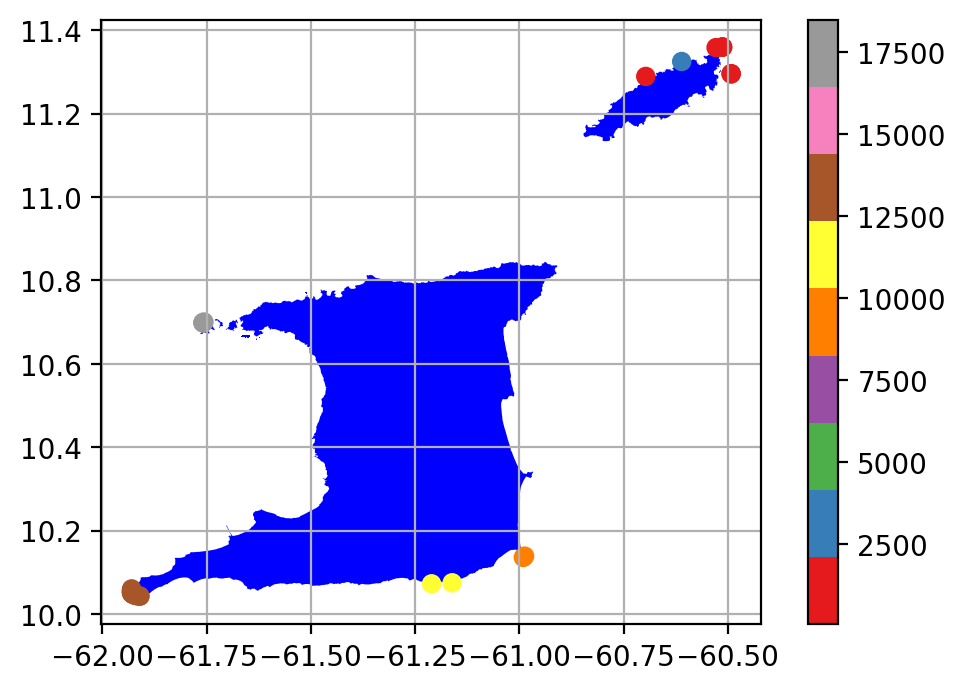

In [852]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

polygons.plot(ax=ax, color='b')

points = []

for node_index in convex_nodes:
    points.append(shapely.geometry.Point([lon[node_index], lat[node_index]]))
    
points = geopandas.GeoDataFrame({'edges': points, 'id':convex_nodes}).set_geometry('edges')
points.plot(ax=ax,  column='id', legend=True, cmap='Set1')